In [83]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ['DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Palatino', 'Charter', 'serif'],
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.title_fontsize": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "lines.linewidth": 2,
    "lines.markersize": 6,
    "legend.frameon": False,
    "figure.figsize": (9, 3)  # standard size for subplots
})
COLORS = ['#4c90b8', '#2ac3c1', '#f5b811', '#de653e', '#ff912a']
color_dict = {
    'BaselineAll': 'black',
    'BaselineNone': 'gray',
    'DisagreementSampling(DT)': COLORS[3],
    'DisagreementSampling(DS)': COLORS[4],
    'RandomSampling': COLORS[0],
    # add other sampling methods as needed
}

# 0. Load Results Data

In [85]:
# downstream performance and time results
dfs = []
for file_path in glob.glob('results/aggregated_results/results_downstream_*.csv'):
    dfs.append(pd.read_csv(file_path))
df_all = pd.concat(dfs, ignore_index=True)

df_all['sampling_method'] = df_all['sampling_method'].replace({
    'ConsensusSampling(DT)': 'DisagreementSampling(DT)',
    'ConsensusSampling(DS)': 'DisagreementSampling(DS)'
})

In [86]:
# invert sign for running times
df_all.loc[df_all['metric'] == 'total_time', 'value'] *= -1
df_all.loc[df_all['metric'] == 'sampling_time', 'value'] *= -1
df_all.loc[df_all['metric'] == 'model_time', 'value'] *= -1

# cleaner presentation of brackets
df_clean = df_all.copy()
bracket_cleaner = {40: '0-40', 60: '20-60', 80: '40-80', 100: '60-100', 0: 'all', np.nan: 'all'}
df_clean['bracket'] = df_clean['bracket_max'].map(bracket_cleaner)
df_clean = df_clean.drop(['bracket_min', 'bracket_max', 'mean', 'sampling_strategy', 'n_selected'], axis=1)

# joining corresponding baselines
baseline_none = df_clean[df_clean['sampling_method'] == 'BaselineNone'].drop(['bracket', 'sampling_method', 'n_sample'], axis=1).rename(columns={'value': 'baseline_none'})
baseline_all = df_clean[df_clean['sampling_method'] == 'BaselineAll'].drop(['bracket', 'sampling_method', 'n_sample'], axis=1).rename(columns={'value': 'baseline_all'})
df_clean = df_clean[~df_clean['sampling_method'].isin(['BaselineNone', 'BaselineAll'])]
join_keys = ['dataset', 'n_labeled', 'metric', 'seed', 'model']
df_clean = pd.merge(df_clean, baseline_none, on=join_keys, how='left')
df_clean = pd.merge(df_clean, baseline_all, on=join_keys, how='left')
df_clean_avg = df_clean.groupby(['model', 'dataset', 'n_labeled', 'n_sample', 'sampling_method', 'metric', 'bracket'])[['value', 'baseline_none', 'baseline_all']].mean().reset_index()

# finding the best bracket by AUPRC
df_agg = df_clean_avg[df_clean_avg['metric'] == 'auprc_macro']
idx_max_value = df_agg.groupby(['model', 'dataset', 'n_labeled', 'sampling_method', 'n_sample'])['value'].idxmax()
df_best_bracket = df_agg.loc[idx_max_value]
idx_max_value = df_agg.groupby(['model', 'dataset', 'n_labeled', 'sampling_method'])['value'].idxmax()
df_best_nsample_bracket = df_agg.loc[idx_max_value]

# 1. Sampling vs. All Unlabeled Data vs. None (Rank)

Does sampling generally work?

In [88]:
def create_pivot_baseline_comparison(model="both"):
    if model=="both":
        df_tmp = df_best_nsample_bracket.copy()
    else:
        df_tmp = df_best_nsample_bracket.loc[df_best_nsample_bracket['model'] == model].copy()

    # add columns indicating where sampling beats the baselines
    df_tmp['of_baseline_all'] = (df_tmp['value'] / df_tmp['baseline_all'])*100
    df_tmp['of_baseline_none'] = (df_tmp['value'] / df_tmp['baseline_none'])*100
    df_tmp['none_of_all'] = (df_tmp['baseline_none'] / df_tmp['baseline_all'])*100

    pivot_summary = pd.pivot_table(
        df_tmp,
        index=['n_labeled', 'sampling_method'],
        values=['of_baseline_all', 'of_baseline_none', 'none_of_all'],#, 'dataset'], 
        aggfunc={
            'of_baseline_all': 'mean',
            'of_baseline_none': 'mean',
            'none_of_all': 'mean',
            # 'dataset': 'nunique'  # Added nunique for dataset
        }
    )
    pivot_summary['BaselineNone % of BaselineAll'] = pivot_summary.apply(
        lambda row: f"{int(row['none_of_all'])}",
        axis=1
    )
    pivot_summary['% of BaselineAll'] = pivot_summary.apply(
        lambda row: f"{int(row['of_baseline_all'])}",
        axis=1
    )
    pivot_summary['% of BaselineNone'] = pivot_summary.apply(
        lambda row: f"{int(row['of_baseline_none'])}",
        axis=1
    )

    pivot_summary = pivot_summary.drop(columns=['of_baseline_all', 'of_baseline_none', 'none_of_all', 'BaselineNone % of BaselineAll'])
    pivot_summary.rename(columns={'dataset': 'Total Datasets'}, inplace=True)
    return pivot_summary


In [89]:
pivot_summary = create_pivot_baseline_comparison("both")
pivot_summary

% of BaselineAll % of BaselineNone
n_labeled sampling_method                                            
50        DisagreementSampling(DS)              101               103
          DisagreementSampling(DT)              101               103
          RandomSampling                        100               102
100       DisagreementSampling(DS)              100               106
          DisagreementSampling(DT)              101               106
          RandomSampling                         99               104
150       DisagreementSampling(DS)              101               106
          DisagreementSampling(DT)              101               105
          RandomSampling                         98               102
200       DisagreementSampling(DS)               99               104
          DisagreementSampling(DT)               99               104
          RandomSampling                         98               102
350       DisagreementSampling(DS)               99               103
          DisagreementSampling(DT)               99               103
          RandomSampling                         98               102
500       DisagreementSampling(DS)               99               102
          DisagreementSampling(DT)               99               102
          RandomSampling                         98               101
750       DisagreementSampling(DS)               99               102
          DisagreementSampling(DT)              100               102
          RandomSampling                         99               101
1000      DisagreementSampling(DS)              100               102
          DisagreementSampling(DT)              100               101
          RandomSampling                         99               101

In [93]:
# latex_str = pivot_summary.to_latex(index=True, escape=False)
# print(latex_str)

In [91]:
pivot_summary = create_pivot_baseline_comparison("TabNet")
pivot_summary

% of BaselineAll % of BaselineNone
n_labeled sampling_method                                            
50        DisagreementSampling(DS)              102               106
          DisagreementSampling(DT)              102               106
          RandomSampling                        100               104
100       DisagreementSampling(DS)              100               111
          DisagreementSampling(DT)              100               112
          RandomSampling                         97               108
150       DisagreementSampling(DS)              102               110
          DisagreementSampling(DT)              101               109
          RandomSampling                         96               104
200       DisagreementSampling(DS)               98               107
          DisagreementSampling(DT)               98               107
          RandomSampling                         96               105
350       DisagreementSampling(DS)               97               105
          DisagreementSampling(DT)               97               105
          RandomSampling                         96               104
500       DisagreementSampling(DS)               97               103
          DisagreementSampling(DT)               97               104
          RandomSampling                         96               103
750       DisagreementSampling(DS)               98               103
          DisagreementSampling(DT)               98               104
          RandomSampling                         97               102
1000      DisagreementSampling(DS)               99               103
          DisagreementSampling(DT)               99               102
          RandomSampling                         98               102

In [92]:
pivot_summary = create_pivot_baseline_comparison("Scarf")
pivot_summary

% of BaselineAll % of BaselineNone
n_labeled sampling_method                                            
50        DisagreementSampling(DS)              101               100
          DisagreementSampling(DT)              101               101
          RandomSampling                        100               100
100       DisagreementSampling(DS)              101               101
          DisagreementSampling(DT)              101               101
          RandomSampling                        100               100
150       DisagreementSampling(DS)              101               101
          DisagreementSampling(DT)              101               101
          RandomSampling                        100               100
200       DisagreementSampling(DS)              100               101
          DisagreementSampling(DT)              100               100
          RandomSampling                        100               100
350       DisagreementSampling(DS)              101               101
          DisagreementSampling(DT)              100               100
          RandomSampling                        100               100
500       DisagreementSampling(DS)              100               100
          DisagreementSampling(DT)              100               101
          RandomSampling                        100               100
750       DisagreementSampling(DS)              101               101
          DisagreementSampling(DT)              101               101
          RandomSampling                        100               100
1000      DisagreementSampling(DS)              100               101
          DisagreementSampling(DT)              101               101
          RandomSampling                        100               100

# 2. n_sample

How much do we need to sample?

In [94]:
df_plot = df_best_bracket.copy()
df_plot['% of BaselineAll'] = 100 * df_plot['value'] / df_plot['baseline_all']
df_plot['sampling_method'] = df_plot['sampling_method'].astype(str)

# Add baseline lines as "sampling methods", preserving n_labeled
df_none = df_plot[['model', 'n_sample', 'n_labeled', 'baseline_none', 'baseline_all']].copy()
df_none['% of BaselineAll'] = 100 * df_none['baseline_none'] / df_none['baseline_all']
df_none['sampling_method'] = 'BaselineNone'

df_all = df_plot[['model', 'n_sample', 'n_labeled']].drop_duplicates().copy()
df_all['% of BaselineAll'] = 100
df_all['sampling_method'] = 'BaselineAll'

df_plot = pd.concat([
    df_plot[['model', 'n_sample', 'n_labeled', 'sampling_method', '% of BaselineAll']],
    df_none[['model', 'n_sample', 'n_labeled', 'sampling_method', '% of BaselineAll']],
    df_all
], ignore_index=True)

In [95]:
def nsample_split_by_nlabeled_plot(model="both"):
    if model=="both":
        df_tmp = df_plot.copy()
    else:
        df_tmp = df_plot.loc[df_plot['model'] == model].copy()

    g = sns.relplot(
        data=df_tmp,
        x='n_sample',
        y='% of BaselineAll',
        hue='sampling_method',
        col='n_labeled',
        kind='line',
        palette=color_dict,
        facet_kws={'sharey': True, 'sharex': True},
        col_wrap=4,
        errorbar=None,
        height=2, aspect=0.8,
    )

    g.set_axis_labels('n_sample', 'AUPRC\n% of BaselineAll')

    # Force legend creation if missing
    g._legend.remove()
    g._legend = g.fig.legend(
        handles=g._legend_data.values(),
        labels=g._legend_data.keys(),
        title='Sampling Method',
        loc='lower center',
        bbox_to_anchor=(0.5, -0.2),
        ncol=3,
        frameon=False
    )

    plt.subplots_adjust(bottom=0.25)  # Adjust space to make room
    plt.tight_layout()
    plt.savefig(f'plots/1_2_nsample_split_by_nlabeled_all_{model}.pdf', bbox_inches='tight')
    plt.show()

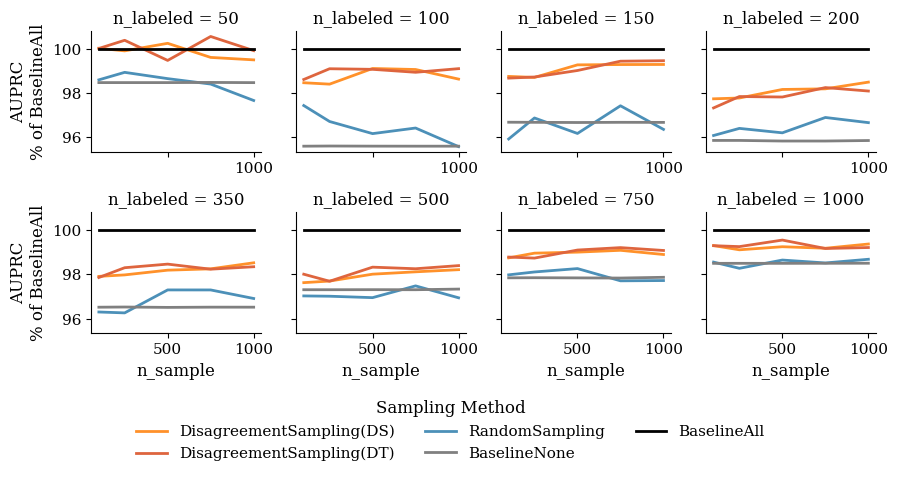

In [96]:
nsample_split_by_nlabeled_plot(model="both")

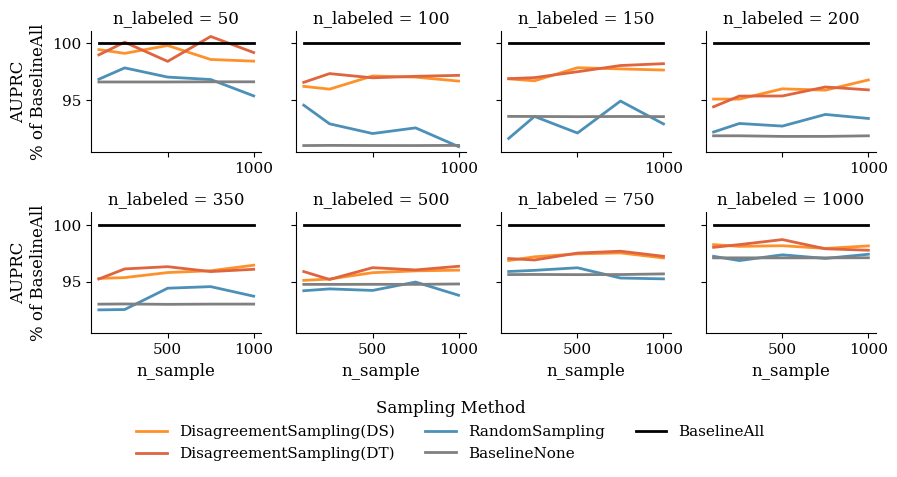

In [97]:
nsample_split_by_nlabeled_plot(model="TabNet")

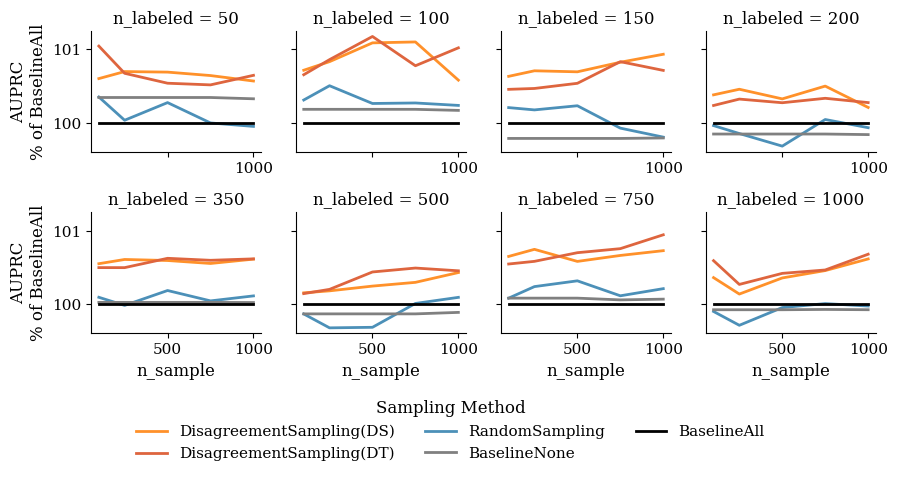

In [98]:
nsample_split_by_nlabeled_plot(model="Scarf")

In [99]:
def nsample_plot(model="both"):
    if model=="both":
        df_tmp = df_plot.copy()
    else:
        df_tmp = df_plot.loc[df_plot['model'] == model].copy()

    fig, ax = plt.subplots(figsize=(6, 2))  # Set width and height in inches

    g = sns.lineplot(
        data=df_tmp,
        x='n_sample',
        y='% of BaselineAll',
        hue='sampling_method',
        palette=color_dict,
        errorbar=None,
        ax=ax
    )

    ax.set_xlabel('n_sample')
    ax.set_ylabel('AUPRC\n% of BaselineAll')

    # Move legend to the right outside the plot
    legend = ax.legend(
        title='Sampling Method',
        bbox_to_anchor=(1.1, 0.5),
        loc='center left',
        borderaxespad=0,
        frameon=False
    )

    plt.tight_layout()
    plt.savefig(f'plots/1_2_nsample_{model}.pdf', bbox_inches='tight')
    plt.show()

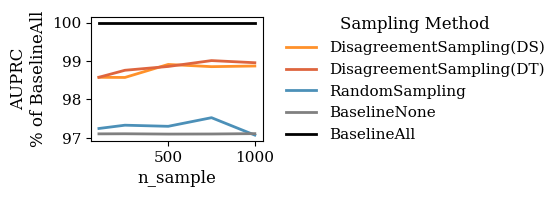

In [100]:
nsample_plot(model="both")

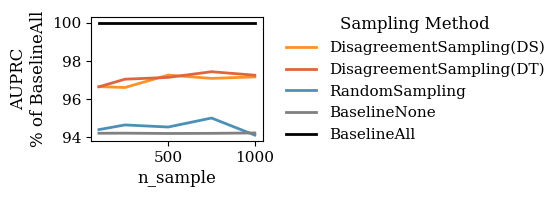

In [101]:
nsample_plot(model="TabNet")

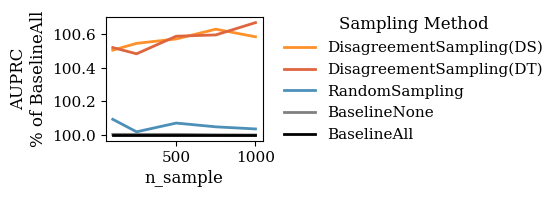

In [102]:
nsample_plot(model="Scarf")

In [103]:
df_tmp = df_best_bracket.copy()

df_filtered = df_tmp[
    (df_tmp['sampling_method'] == 'DisagreementSampling(DT)') &
    (df_tmp['n_labeled'].isin([100, 1000])) &
    (df_tmp['n_sample'].isin([100, 500, 1000]))
].copy()

df_filtered['n_sample'] = df_filtered['n_sample'].astype(str)

# Create 'none' rows from baseline_none
df_none = df_filtered[['model', 'n_labeled', 'baseline_none']].copy()
df_none = df_none.rename(columns={'baseline_none': 'value'})
df_none['n_sample'] = 'none'

# Create 'all' rows from baseline_all
df_all = df_filtered[['model', 'n_labeled', 'baseline_all']].copy()
df_all = df_all.rename(columns={'baseline_all': 'value'})
df_all['n_sample'] = 'all'

# Combine
cols = ['model', 'n_labeled', 'n_sample', 'value']
df_combined = pd.concat([
    df_filtered[cols],
    df_none[cols],
    df_all[cols]
], ignore_index=True)

n_sample_order = pd.api.types.CategoricalDtype(['none', '100', '500', '1000', 'all'], ordered=True)
df_combined['n_sample'] = df_combined['n_sample'].astype(n_sample_order)

# Pivot
pivot = pd.pivot_table(
    df_combined,
    index='model',
    columns=['n_labeled', 'n_sample'],
    values='value',
    aggfunc='mean',
    observed=False
).sort_index(axis=1, level=0)

pivot

n_labeled      100                                               1000  \
n_sample       none       100       500      1000       all      none   
model                                                                   
Scarf      0.290097  0.291494  0.291712  0.291657  0.289796  0.289571   
TabNet     0.385619  0.403596  0.403214  0.406070  0.412360  0.705905   

n_labeled                                          
n_sample        100       500      1000       all  
model                                              
Scarf      0.290769  0.290567  0.291534  0.289429  
TabNet     0.711264  0.715252  0.709964  0.714684

In [36]:
# print(pivot.to_latex())

# 3. Brackets

Which disagreement bracket makes the most sense?

In [104]:
def brackets_plot(model="both"):
    if model=="both":
        df_tmp = df_clean.copy()
    else:
        df_tmp = df_clean.loc[df_clean['model'] == model].copy()

    df_plot = df_tmp[df_tmp['metric'] == 'auprc_macro']
    rand_vals = df_plot[df_plot['sampling_method'] == 'RandomSampling']['value']
    rand_mean = rand_vals.mean()
    rand_std = rand_vals.std()

    plt.figure(figsize=(6, 2))
    ax = plt.gca()

    # Add horizontal band for RandomSampling
    ax.axhline(rand_mean, color=color_dict['RandomSampling'], linestyle='-', label='RandomSampling')
    ax.fill_between(
        x=[-0.5, len(df_plot['bracket'].unique()) - 1.5],
        y1=rand_mean - rand_std,
        y2=rand_mean + rand_std,
        color=color_dict['RandomSampling'],
        alpha=0.2
    )

    sns.boxplot(
        data=df_plot[df_plot['sampling_method'] != 'RandomSampling'],
        x="bracket",
        y="value",
        hue="sampling_method",
        palette=color_dict,
        width=0.5
    )

    plt.ylabel('AUPRC')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='Sampling Method', bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig(f'plots/1_3_brackets_{model}.pdf', bbox_inches='tight')
    plt.show()

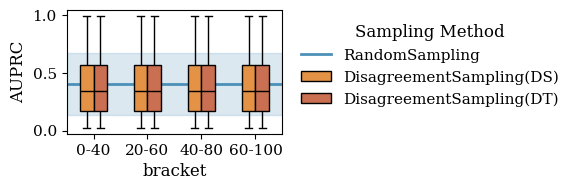

In [105]:
brackets_plot(model="both")

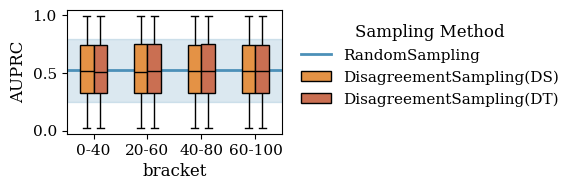

In [106]:
brackets_plot(model="TabNet")

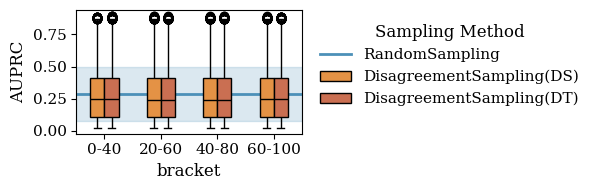

In [107]:
brackets_plot(model="Scarf")

In [108]:
def brackets_split_by_dataset_plot(model="both"):
    if model=="both":
        df_tmp = df_clean.copy()
    else:
        df_tmp = df_clean.loc[df_clean['model'] == model].copy()

    # Filter relevant data
    df_plot = df_tmp[df_tmp['metric'] == 'auprc_macro']
    rand_vals = df_plot[df_plot['sampling_method'] == 'RandomSampling']['value']
    rand_mean = rand_vals.mean()
    rand_std = rand_vals.std()

    # Exclude RandomSampling from the boxplot data
    df_no_rand = df_plot[df_plot['sampling_method'] != 'RandomSampling']

    # Create faceted boxplots by dataset
    g = sns.catplot(
        data=df_no_rand,
        x="bracket",
        y="value",
        hue="sampling_method",
        col="dataset",
        col_wrap=4,
        kind="box",
        palette=color_dict,
        height=1.5,
        aspect=2,
        sharey=True
    )

    # Add horizontal line and band to each subplot
    for ax in g.axes.flat:
        ax.axhline(rand_mean, color=color_dict['RandomSampling'], linestyle='-')
        ax.fill_between(
            x=[-0.5, len(df_plot['bracket'].unique()) - 1.5],
            y1=rand_mean - rand_std,
            y2=rand_mean + rand_std,
            color=color_dict['RandomSampling'],
            alpha=0.2,
            zorder=0
        )

    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("bracket", "AUPRC")

    g._legend.remove()
    g.fig.legend(
        handles=g._legend_data.values(),
        labels=g._legend_data.keys(),
        title="Sampling Method",
        loc="lower center",
        bbox_to_anchor=(0.425, -0.06),
        ncol=3,
        frameon=False
    )

    plt.savefig(f'plots/1_3_brackets_split_by_dataset_{model}.pdf', bbox_inches='tight')
    plt.show()

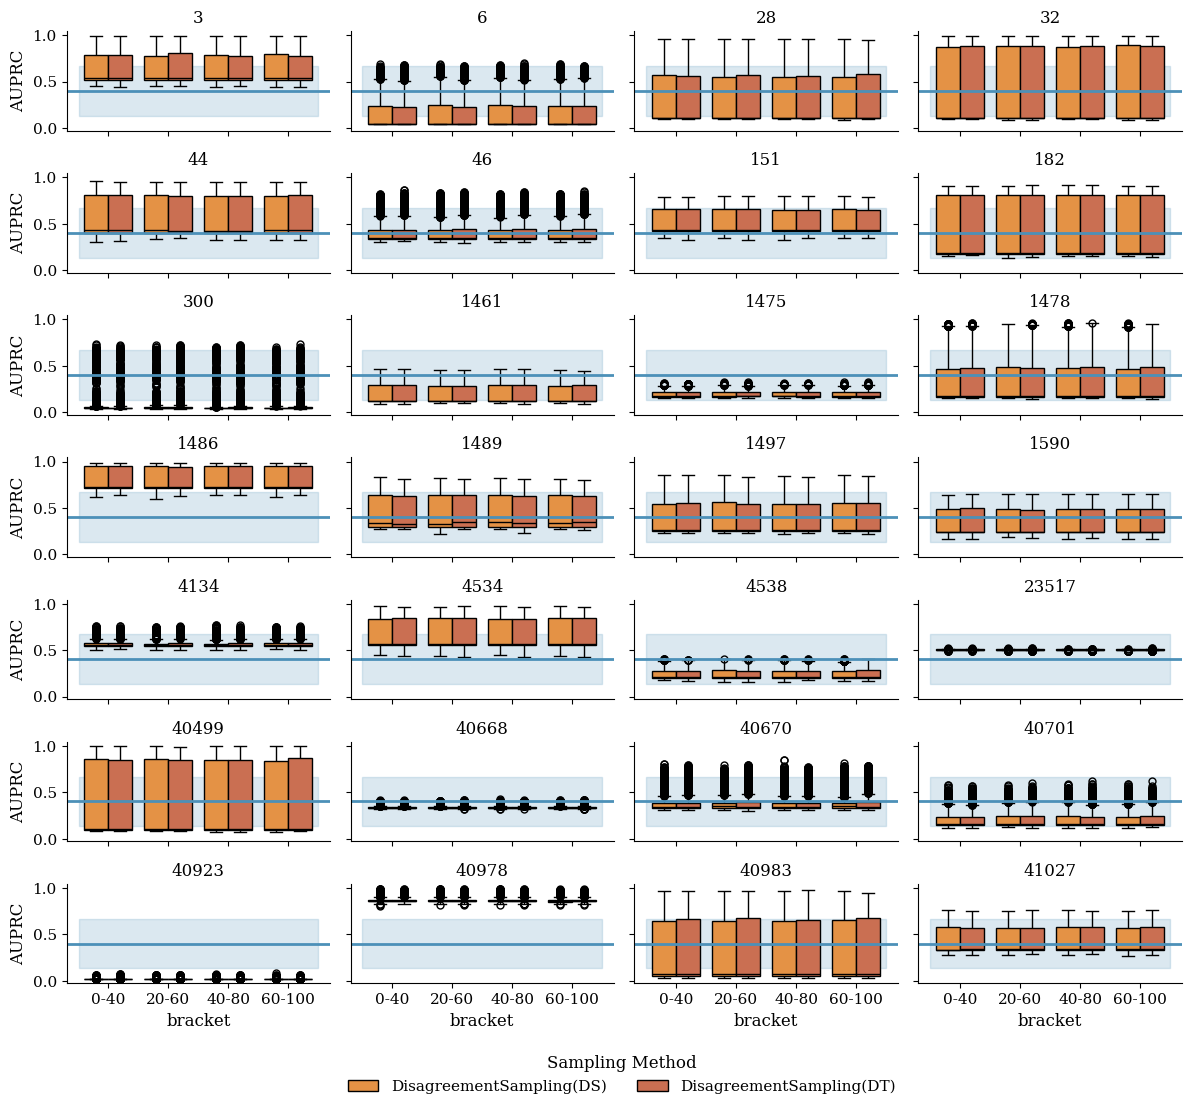

In [109]:
brackets_split_by_dataset_plot(model="both")

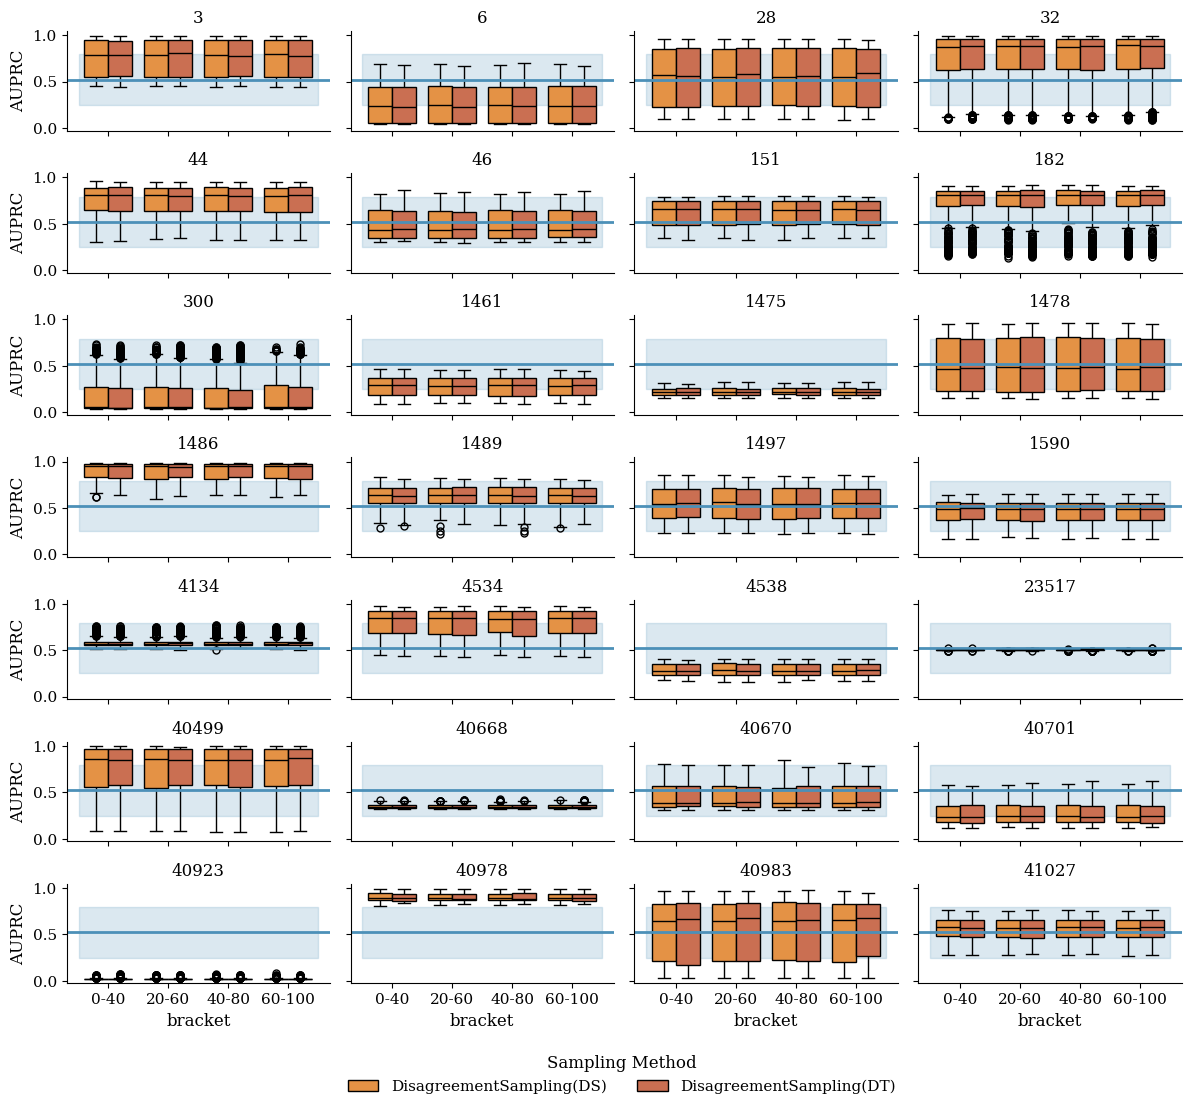

In [110]:
brackets_split_by_dataset_plot(model="TabNet")

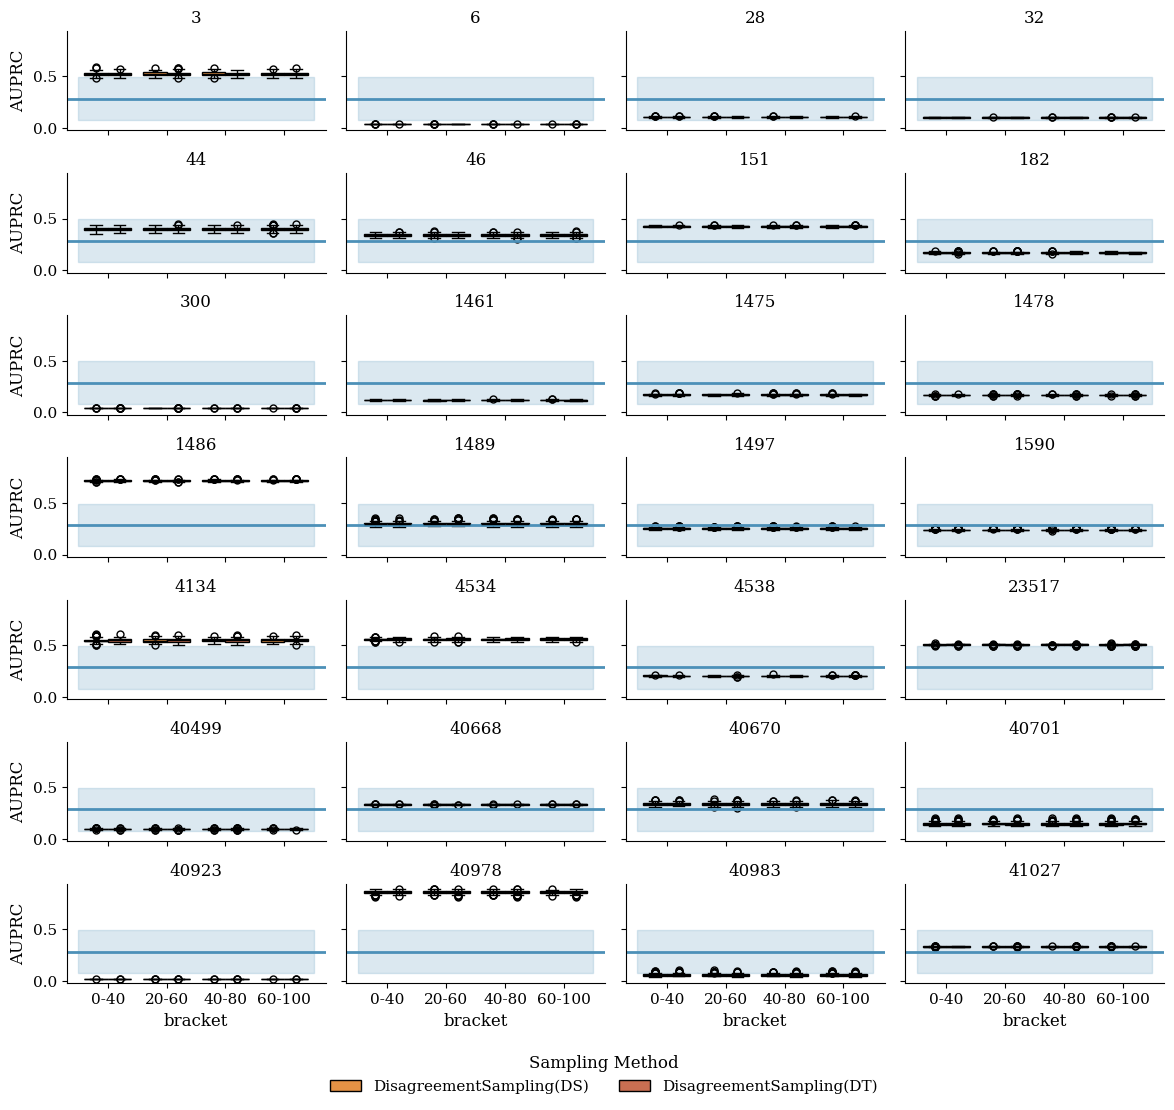

In [111]:
brackets_split_by_dataset_plot(model="Scarf")